In [2]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
%matplotlib inline

## Get the SSA Names Dataset

In [120]:
!wget https://raw.githubusercontent.com/hackerb9/ssa-baby-names/main/allnames.txt
# !wget https://raw.githubusercontent.com/karpathy/makemore/master/names.txt

--2024-10-03 22:07:01--  https://raw.githubusercontent.com/hackerb9/ssa-baby-names/main/allnames.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 755579 (738K) [text/plain]
Saving to: ‘allnames.txt’

allnames.txt        100%[===================>] 737.87K  --.-KB/s    in 0.008s  

2024-10-03 22:07:01 (95.3 MB/s) - ‘allnames.txt’ saved [755579/755579]



In [121]:
words = open('allnames.txt').read().lower().splitlines()
# words = open('names.txt').read().lower().splitlines()
words[:20]

['linda',
 'james',
 'michael',
 'robert',
 'john',
 'david',
 'mary',
 'william',
 'jennifer',
 'lisa',
 'christopher',
 'richard',
 'mark',
 'patricia',
 'jessica',
 'jason',
 'ashley',
 'deborah',
 'debra',
 'matthew']

#### Analysis

In [122]:
len(words)

100364

In [123]:
# Build the vocabulary of characters and mappings to/from integers

chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
print(itos)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


## Dataset & NN

#### Create X & Y Data

In [124]:
block_size = 3

X, Y = [], []
for w in words[:5]:
  print(w)
  context = [0] * block_size

  for ch in w + '.':
    ix = stoi[ch]
    X.append(context)
    Y.append(ix)
    print(''.join(itos[i] for i in context), '--->', itos[ix])
    context = context[1:] + [ix]                                  # crop and append

X = torch.tensor(X)
Y = torch.tensor(Y)

linda
... ---> l
..l ---> i
.li ---> n
lin ---> d
ind ---> a
nda ---> .
james
... ---> j
..j ---> a
.ja ---> m
jam ---> e
ame ---> s
mes ---> .
michael
... ---> m
..m ---> i
.mi ---> c
mic ---> h
ich ---> a
cha ---> e
hae ---> l
ael ---> .
robert
... ---> r
..r ---> o
.ro ---> b
rob ---> e
obe ---> r
ber ---> t
ert ---> .
john
... ---> j
..j ---> o
.jo ---> h
joh ---> n
ohn ---> .


In [125]:
X.shape, X.dtype, Y.shape, Y.dtype

(torch.Size([32, 3]), torch.int64, torch.Size([32]), torch.int64)

#### Embedd

> Cram the entire characters into a lower dimensional embedding space

> So, all the 27 characters will have a n-dim embedding (let's say n=2)

In [126]:
C = torch.randn((27, 2))
C

tensor([[-0.0252, -2.1761],
        [ 1.5602, -0.8583],
        [ 0.5499,  0.2516],
        [ 0.2905, -0.7509],
        [-0.2548, -1.5441],
        [ 0.4015, -0.2453],
        [-2.0464,  2.0091],
        [-0.0403, -0.7020],
        [ 2.1457,  0.4548],
        [ 0.2744,  0.1667],
        [-1.2447, -0.9151],
        [-1.1632,  0.4243],
        [ 1.4231, -0.4863],
        [-0.5001,  0.4112],
        [-1.3005,  0.3375],
        [-0.3839, -1.9458],
        [ 0.8606,  0.1597],
        [-0.6835, -1.7186],
        [-1.6194,  0.5330],
        [-1.0462, -1.4003],
        [ 1.5672,  1.2444],
        [ 0.6034,  0.7418],
        [-0.3505,  0.1460],
        [-1.8453, -1.2811],
        [ 1.1641, -0.1324],
        [ 0.1489, -1.5965],
        [ 0.4774,  2.1563]])

In [127]:
C[5]

tensor([ 0.4015, -0.2453])

In [128]:
# Using One-Hot Enncoding (Costiler than Simple Encoding)
F.one_hot(torch.tensor(5), num_classes=27).float() @ C

# 1 x 27 @ 27 x 2

tensor([ 0.4015, -0.2453])

#### The Hidden Layer

> But now comes a problem. We want to multiply W @ C + b

> But C = (32, 3, 2); W = (6, 100); b = (100)

> So, we need to concatente the embeddings of C into one dimension (unbind the dimension & add them to the vector)

> Or simply change the view of the vector

In [129]:
emb = C[X]
emb.shape

torch.Size([32, 3, 2])

In [130]:
# torch.cat([emb[:, 0, :], emb[:, 1, :], emb[:, 1, :]], 1).shape
# unbinded = torch.unbind(emb, 1)
# torch.cat(unbinded, 1).shape

# OR

emb.view(emb.shape[0], 6)

tensor([[-0.0252, -2.1761, -0.0252, -2.1761, -0.0252, -2.1761],
        [-0.0252, -2.1761, -0.0252, -2.1761,  1.4231, -0.4863],
        [-0.0252, -2.1761,  1.4231, -0.4863,  0.2744,  0.1667],
        [ 1.4231, -0.4863,  0.2744,  0.1667, -1.3005,  0.3375],
        [ 0.2744,  0.1667, -1.3005,  0.3375, -0.2548, -1.5441],
        [-1.3005,  0.3375, -0.2548, -1.5441,  1.5602, -0.8583],
        [-0.0252, -2.1761, -0.0252, -2.1761, -0.0252, -2.1761],
        [-0.0252, -2.1761, -0.0252, -2.1761, -1.2447, -0.9151],
        [-0.0252, -2.1761, -1.2447, -0.9151,  1.5602, -0.8583],
        [-1.2447, -0.9151,  1.5602, -0.8583, -0.5001,  0.4112],
        [ 1.5602, -0.8583, -0.5001,  0.4112,  0.4015, -0.2453],
        [-0.5001,  0.4112,  0.4015, -0.2453, -1.0462, -1.4003],
        [-0.0252, -2.1761, -0.0252, -2.1761, -0.0252, -2.1761],
        [-0.0252, -2.1761, -0.0252, -2.1761, -0.5001,  0.4112],
        [-0.0252, -2.1761, -0.5001,  0.4112,  0.2744,  0.1667],
        [-0.5001,  0.4112,  0.2744,  0.1

In [131]:
emb.view(emb.shape[0], 6) == torch.cat(torch.unbind(emb, 1), 1)

tensor([[True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, T

In [132]:
# Hidden Layer 1

W1 = torch.randn((6, 100))
b1 = torch.randn(100)

# W1.shape, b1.shape

h = emb.view(emb.shape[0], 6) @ W1 + b1
h.shape

torch.Size([32, 100])

In [133]:
# tanh

h = torch.tanh(h)
h

tensor([[-1.0000,  0.3921,  0.9892,  ...,  0.9997, -0.4537,  0.9992],
        [-0.9990, -0.8394,  0.9878,  ...,  1.0000, -0.9653,  0.6087],
        [-0.9996,  0.9836,  0.9795,  ..., -0.4845, -0.9602, -0.9261],
        ...,
        [-1.0000, -0.6528,  0.9562,  ...,  0.8385,  0.5671,  0.9995],
        [ 0.9893, -0.9994,  0.9886,  ...,  1.0000, -0.9804,  0.9673],
        [-0.9999,  0.9999,  0.6752,  ..., -1.0000, -0.9171, -0.8608]])

In [134]:
# Hidden Layer 2

W2 = torch.randn((100, 27))
b2 = torch.randn(27)

logits = h @ W2 + b2
logits.shape

torch.Size([32, 27])

#### Fake Counts & Normalise

In [135]:
counts = logits.exp()
probs = counts / counts.sum(1, keepdims=True)
probs.shape

torch.Size([32, 27])

In [136]:
loss = -probs[torch.arange(32), Y].log().mean()
loss

tensor(17.8255)

#### NN Hidden Layers

In [137]:
X.shape, Y.shape

(torch.Size([32, 3]), torch.Size([32]))

In [57]:
g = torch.Generator().manual_seed(2147483647) # for reproducibility
C = torch.randn((27, 2), generator=g)

W1 = torch.randn((6, 100), generator=g)
b1 = torch.randn(100, generator=g)

W2 = torch.randn((100, 27), generator=g)
b2 = torch.randn(27, generator=g)

parameters = [C, W1, b1, W2, b2]

In [67]:
for p in parameters:
  p.requires_grad = True

sum(p.nelement() for p in parameters)

3481

In [100]:
# Forward Pass

emb = C[X]
h = torch.tanh(emb.view(-1, 6) @ W1 + b1)
logits = h @ W2 + b2

# counts = logits.exp()
# probs = counts / counts.sum(1, keepdims=True)
# loss = -probs[torch.arange(32), Y].log().mean()

# OR

loss = F.cross_entropy(logits, Y)

loss.item()

3.985848903656006

In [101]:
# Backward Pass

for p in parameters:
  p.grad = None

loss.backward()

In [102]:
# Update

for p in parameters:
  p.data += -0.1 * p.grad

In [103]:
for i in range(100):
  # Forward Pass
  emb = C[X]
  h = torch.tanh(emb.view(-1, 6) @ W1 + b1)
  logits = h @ W2 + b2

  # counts = logits.exp()
  # probs = counts / counts.sum(1, keepdims=True)
  # loss = -probs[torch.arange(32), Y].log().mean()

  # OR

  loss = F.cross_entropy(logits, Y)

  print(f'{loss.item()}')

  # Backward Pass
  for p in parameters:
    p.grad = None

  loss.backward()

  # Update
  for p in parameters:
    p.data += -0.1 * p.grad

3.6028308868408203
3.2621419429779053
2.961381196975708
2.6982977390289307
2.469712972640991
2.271660327911377
2.101283550262451
1.9571774005889893
1.8374857902526855
1.7380965948104858
1.6535115242004395
1.579089879989624
1.5117665529251099
1.4496047496795654
1.3913120031356812
1.335992455482483
1.283052921295166
1.2321909666061401
1.18338143825531
1.1367990970611572
1.092664122581482
1.0510923862457275
1.0120267868041992
0.9752704501152039
0.9405565857887268
0.9076125025749207
0.8761921525001526
0.8460890650749207
0.817135751247406
0.7891992330551147
0.7621746063232422
0.7359814047813416
0.7105579972267151
0.6858609318733215
0.6618651747703552
0.6385656595230103
0.6159818172454834
0.5941657423973083
0.5732105374336243
0.553256094455719
0.5344880819320679
0.5171167254447937
0.5013312697410583
0.48724257946014404
0.4748404920101166
0.4639975428581238
0.45451444387435913
0.4461706876754761
0.4387663006782532
0.43213313817977905
0.4261389374732971
0.42067983746528625
0.4156753718852997
0

## Final NN

In [138]:
# Build the Dataset

block_size = 3                    # context length: how many characters do we take to predict the next one?

def build_dataset(words):
  X, Y = [], []
  for w in words:

    #print(w)
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      #print(''.join(itos[i] for i in context), '--->', itos[ix])
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([604277, 3]) torch.Size([604277])
torch.Size([75659, 3]) torch.Size([75659])
torch.Size([75643, 3]) torch.Size([75643])


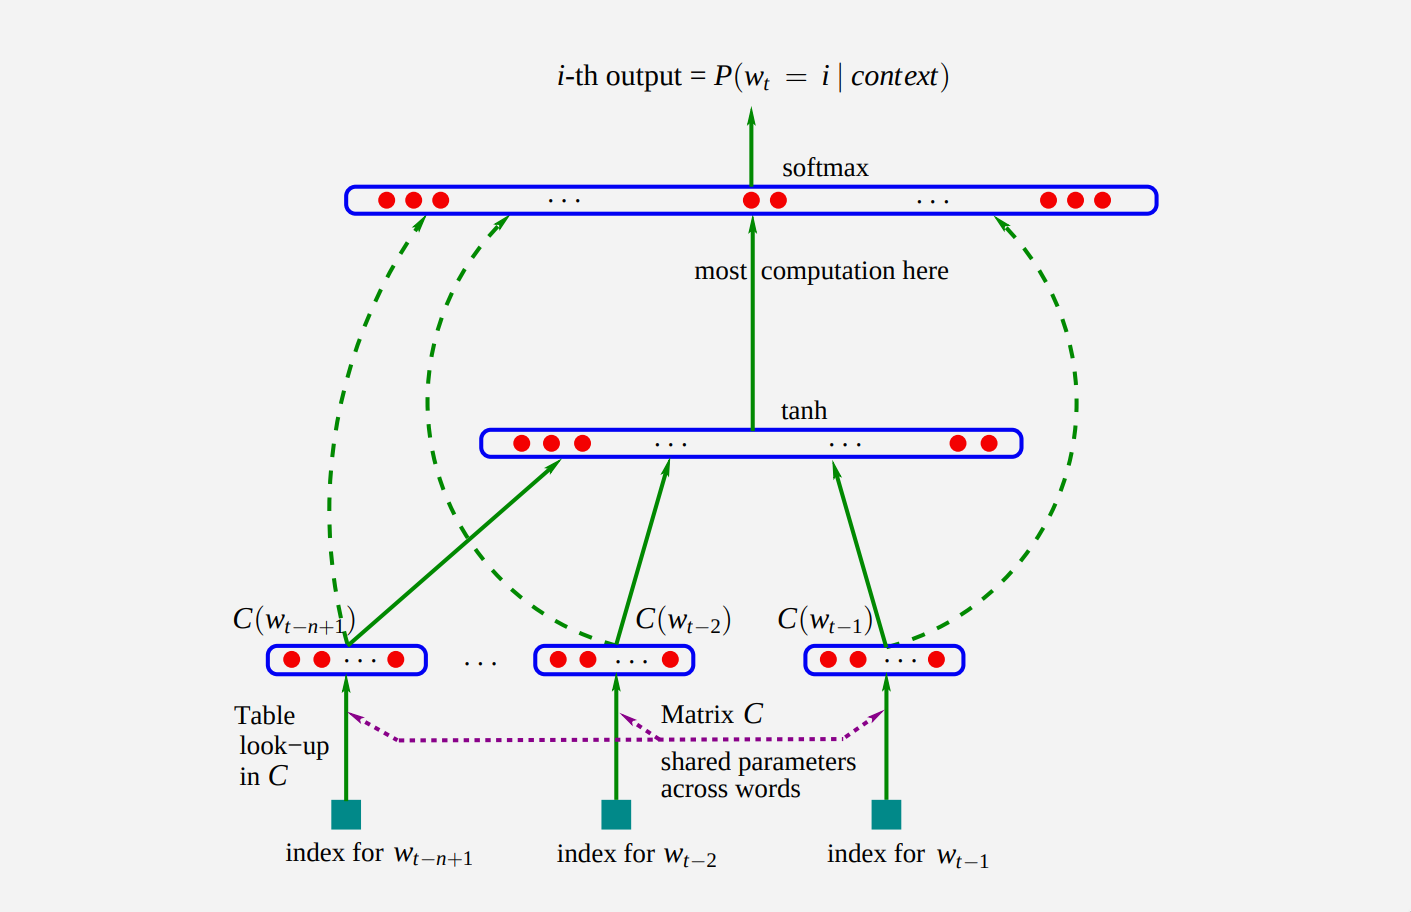

In [139]:
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27, 10), generator=g)

W1 = torch.randn((30, 200), generator=g)
b1 = torch.randn(200, generator=g)

W2 = torch.randn((200, 27), generator=g)
b2 = torch.randn(27, generator=g)

parameters = [C, W1, b1, W2, b2]

In [140]:
sum(p.nelement() for p in parameters) # number of parameters in total

11897

In [141]:
for p in parameters:
  p.requires_grad = True

In [142]:
lre = torch.linspace(-3, 0, 1000)
lrs = 10**lre

In [143]:
lri = []
lossi = []
stepi = []

In [145]:
iters = 200000

for i in range(iters):

  # Minibatch Construct
  ix = torch.randint(0, Xtr.shape[0], (32,))

  # Forward Pass
  emb = C[Xtr[ix]]                                        # (32, 3, 2)
  h = torch.tanh(emb.view(-1, 30) @ W1 + b1)              # (32, 100)
  logits = h @ W2 + b2                                    # (32, 27)
  loss = F.cross_entropy(logits, Ytr[ix])
  #print(loss.item())

  # Backward Pass
  for p in parameters:
    p.grad = None
  loss.backward()

  # Update
  #lr = lrs[i]
  lr = 0.1 if i < iters/2 else 0.01
  for p in parameters:
    p.data += -lr * p.grad

  # Track Stats
  #lri.append(lre[i])
  stepi.append(i)
  lossi.append(loss.log10().item())

  if i % (iters/10) == 0 or i == iters-1:
    print(f"{i:7d}/{iters-1:7d}: {loss.item():.4f}")

#print(loss.item())

      0/ 199999: 2.0144
  20000/ 199999: 2.5201
  40000/ 199999: 2.6547
  60000/ 199999: 2.4888
  80000/ 199999: 2.5244
 100000/ 199999: 2.1495
 120000/ 199999: 2.1702
 140000/ 199999: 2.1641
 160000/ 199999: 2.0628
 180000/ 199999: 2.2784
 199999/ 199999: 1.9031


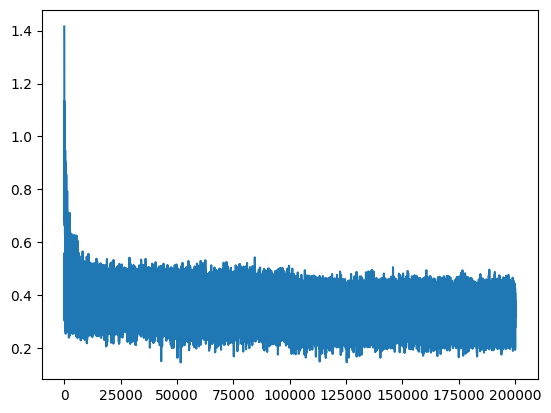

In [146]:
plt.plot(stepi, lossi)

In [147]:
# Training Loss
emb = C[Xtr]                                          # (32, 3, 2)
h = torch.tanh(emb.view(-1, 30) @ W1 + b1)            # (32, 100)
logits = h @ W2 + b2                                  # (32, 27)
loss = F.cross_entropy(logits, Ytr)
loss

tensor(2.1850, grad_fn=<NllLossBackward0>)

In [148]:
# validation loss
emb = C[Xdev]                                         # (32, 3, 2)
h = torch.tanh(emb.view(-1, 30) @ W1 + b1)            # (32, 100)
logits = h @ W2 + b2                                  # (32, 27)
loss = F.cross_entropy(logits, Ydev)
loss

tensor(2.1929, grad_fn=<NllLossBackward0>)

In [149]:
# test loss
emb = C[Xte]                                          # (32, 3, 2)
h = torch.tanh(emb.view(-1, 30) @ W1 + b1)            # (32, 100)
logits = h @ W2 + b2                                  # (32, 27)
loss = F.cross_entropy(logits, Yte)
loss

tensor(2.2011, grad_fn=<NllLossBackward0>)

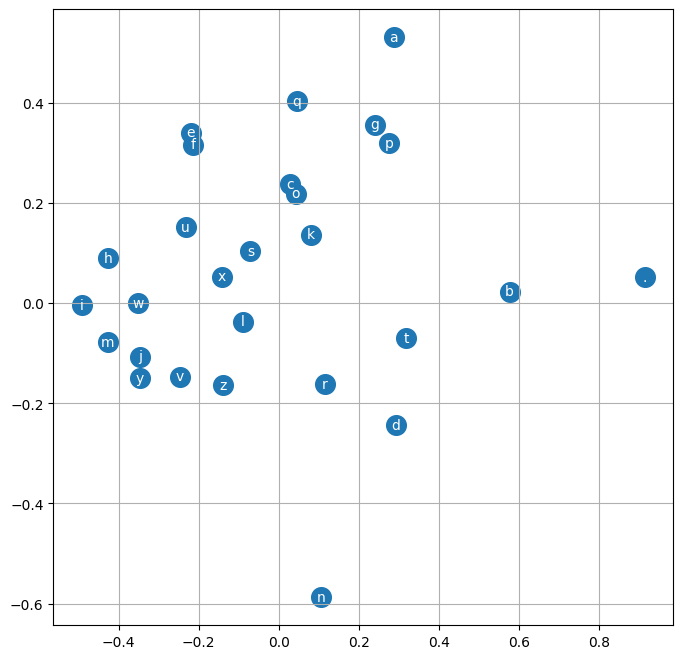

In [150]:
# Visualize Dimensions 0 and 1 of The Embedding Matrix C for All Characters
plt.figure(figsize=(8,8))
plt.scatter(C[:,0].data, C[:,1].data, s=200)
for i in range(C.shape[0]):
    plt.text(C[i,0].item(), C[i,1].item(), itos[i], ha="center", va="center", color='white')
plt.grid('minor')

In [152]:
# Sample from The Model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(50):

    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      emb = C[torch.tensor([context])] # (1,block_size,d)
      h = torch.tanh(emb.view(1, -1) @ W1 + b1)
      logits = h @ W2 + b2
      probs = F.softmax(logits, dim=1)
      ix = torch.multinomial(probs, num_samples=1, generator=g).item()
      context = context[1:] + [ix]
      out.append(ix)
      if ix == 0:
        break

    print(''.join(itos[i] for i in out))

mondalmyah.
see.
mad.
rylle.
emmantendra.
graderronelin.
shianelle.
elisananaraelynn.
hota.
cayshabergia.
micha.
jaireth.
kranthondo.
breyce.
ruyah.
faeka.
kayshia.
kyan.
hil.
salynn.
une.
alel.
junett.
revis.
jaker.
pardin.
quio.
obhenneica.
amuey.
shhun.
ollia.
siri.
certhwalla.
ortarashikee.
sila.
blita.
kevis.
dely.
mellaketarmiy.
xavon.
damaizekia.
alin.
tud.
aith.
dah.
virle.
ajayera.
moiatrylleamiia.
jovontet.
jynn.


In [153]:
from google.colab import drive
drive.mount('/content/drive')

torch.save(C, '/content/drive/MyDrive/NLP_Project/MLP_C.pt')
torch.save(W1, '/content/drive/MyDrive/NLP_Project/MLP_W1.pt')
torch.save(b1, '/content/drive/MyDrive/NLP_Project/MLP_b1.pt')
torch.save(W2, '/content/drive/MyDrive/NLP_Project/MLP_W2.pt')
torch.save(b2, '/content/drive/MyDrive/NLP_Project/MLP_b2.pt')

Mounted at /content/drive


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

C = torch.load('/content/drive/MyDrive/NLP_Project/MLP_C.pt')
W1 = torch.load('/content/drive/MyDrive/NLP_Project/MLP_W1.pt')
b1 = torch.load('/content/drive/MyDrive/NLP_Project/MLP_b1.pt')
W2 = torch.load('/content/drive/MyDrive/NLP_Project/MLP_W2.pt')
b2 = torch.load('/content/drive/MyDrive/NLP_Project/MLP_b2.pt')
